In [6]:
!pip install --upgrade tqdm opencv-python einops seaborn tensorflow[and-cuda] imageio

In [7]:
from constants import PROCESSED_VIDEOS_DIR, WIDTH, HEIGHT, CLASSES

import pathlib
import json
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers, models
from keras.applications import VGG16
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [8]:
with open('./data/WLASL_v0.3.json', 'r') as file:
  data = json.load(file)

videos = {}
for entry in data:
  if entry["gloss"] in CLASSES:
    for inst in entry["instances"]:
      video = pathlib.Path(PROCESSED_VIDEOS_DIR / f"{inst["video_id"]}.mp4")
      if video.exists():
        videos[inst["video_id"]] = {
          "path": video,
          "split": inst["split"],
          "gloss": entry["gloss"]
        }

split_map = {"train": [], "val": [], "test": []}

for video_id, video in videos.items():
  split_map[video["split"]].append((video["split"], video["gloss"]))

In [4]:
class ConvNet2D(tf.keras.Model):
    def __init__(self, num_classes, hidden_size=128, num_layers=2, dropout_rate=0.2):
        """
        2D Conv RNN model for sign language classification
        
        Args:
            num_classes: Number of sign language classes to predict
            hidden_size: Hidden size for GRU layers (64, 96, 128, or 256 based on subset)
            num_layers: Number of stacked GRU layers (default: 2)
            dropout_rate: Dropout rate for regularization
        """
        super(ConvNet2D, self).__init__()
        
        self.num_classes = num_classes
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # VGG16 backbone for spatial feature extraction
        # Remove the top classification layers and use as feature extractor
        self.vgg16_base = VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=(HEIGHT, WIDTH, 3),
            pooling='avg'  # Global average pooling
        )
        
        # Freeze VGG16 layers (optional - you can unfreeze for fine-tuning)
        self.vgg16_base.trainable = True
        
        # Time distributed wrapper to apply VGG16 to each frame
        self.time_distributed_cnn = layers.TimeDistributed(
            self.vgg16_base,
            name='time_distributed_vgg16'
        )
        
        # Stacked GRU layers
        self.gru_layers = []
        for i in range(num_layers):
            return_sequences = True if i < num_layers - 1 else True  # Always return sequences for pooling
            self.gru_layers.append(
                layers.GRU(
                    hidden_size,
                    return_sequences=return_sequences,
                    dropout=dropout_rate,
                    recurrent_dropout=dropout_rate,
                    name=f'gru_layer_{i+1}'
                )
            )
        
        # Global average pooling over time dimension
        self.global_avg_pool = layers.GlobalAveragePooling1D(name='global_avg_pool')
        
        # Classification head
        self.classifier = layers.Dense(
            num_classes,
            activation='softmax',
            name='classifier'
        )
        
        # Additional dense layer for regularization (optional)
        self.dropout = layers.Dropout(dropout_rate)
        
    def call(self, inputs, training=None):
        """
        Forward pass
        
        Args:
            inputs: Video tensor of shape (batch_size, time_steps, height, width, channels)
            training: Whether in training mode
            
        Returns:
            predictions: Class predictions of shape (batch_size, num_classes)
            all_outputs: All time step outputs for training loss (batch_size, time_steps, num_classes)
        """
        # Extract spatial features using VGG16
        # Input: (batch_size, time_steps, height, width, channels)
        # Output: (batch_size, time_steps, feature_dim)
        spatial_features = self.time_distributed_cnn(inputs, training=training)
        
        # Process through stacked GRU layers
        x = spatial_features
        for gru_layer in self.gru_layers:
            x = gru_layer(x, training=training)
        
        # x shape: (batch_size, time_steps, hidden_size)
        
        # Get predictions for all time steps (for training loss)
        all_time_predictions = layers.TimeDistributed(self.classifier)(x)
        
        # Global average pooling for final prediction
        pooled_features = self.global_avg_pool(x)
        pooled_features = self.dropout(pooled_features, training=training)
        final_prediction = self.classifier(pooled_features)
        
        return final_prediction, all_time_predictions

def create_model(num_classes, hidden_size=128):
    """
    Create and compile the 2D Conv RNN model
    
    Args:
        num_classes: Number of sign language classes
        hidden_size: GRU hidden size (choose from 64, 96, 128, 256 based on subset)
    
    Returns:
        Compiled Keras model
    """
    model = ConvNet2D(
        num_classes=num_classes,
        hidden_size=hidden_size,
        num_layers=2
    )
    
    # Build the model by calling it with dummy input
    dummy_input = tf.random.normal((1, 50, HEIGHT, WIDTH, 3))  # Max 50 frames as mentioned
    _ = model(dummy_input)
    
    return model

def custom_loss_function(y_true, y_pred_tuple):
    """
    Custom loss function that combines:
    1. Cross-entropy loss on final pooled prediction
    2. Cross-entropy loss on all time step predictions
    
    Args:
        y_true: True labels
        y_pred_tuple: Tuple of (final_prediction, all_time_predictions)
    """
    final_pred, all_time_pred = y_pred_tuple
    
    # Loss on final prediction (from average pooling)
    final_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, final_pred)
    
    # Loss on all time step predictions
    # Expand y_true to match time dimension
    time_steps = tf.shape(all_time_pred)[1]
    y_true_expanded = tf.expand_dims(y_true, 1)  # (batch_size, 1)
    y_true_tiled = tf.tile(y_true_expanded, [1, time_steps])  # (batch_size, time_steps)
    
    all_time_loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true_tiled, all_time_pred
    )
    all_time_loss = tf.reduce_mean(all_time_loss, axis=1)  # Average over time
    
    # Combine losses (you can weight them differently)
    total_loss = final_loss + all_time_loss
    
    return total_loss

def preprocess_video_batch(video_data_list, max_frames=50, is_training=True):
    """
    Preprocess a batch of videos for training/testing
    
    Args:
        video_data_list: List of tuples (video_path, gloss) from your split_map
        max_frames: Maximum number of frames to use (50 for training, all for testing)
        is_training: Whether in training mode (affects frame sampling)
    
    Returns:
        batch_videos: Preprocessed video tensor of shape (batch_size, max_time_steps, HEIGHT, WIDTH, 3)
        batch_labels: Labels for the videos
    """
    batch_videos = []
    batch_labels = []
    
    for video_path, gloss in video_data_list:
        try:
            # Load video frames
            frames = load_video_frames(video_path)  # Shape: (num_frames, height, width, channels)
            
            # Resize frames to target size
            frames = tf.image.resize(frames, [HEIGHT, WIDTH])
            
            # Normalize pixel values to [0, 1]
            frames = tf.cast(frames, tf.float32) / 255.0
            
            # Frame sampling strategy
            num_frames = tf.shape(frames)[0]
            
            if is_training:
                # For training: randomly select up to max_frames consecutive frames
                if num_frames > max_frames:
                    start_idx = tf.random.uniform([], 0, num_frames - max_frames + 1, dtype=tf.int32)
                    frames = frames[start_idx:start_idx + max_frames]
            else:
                # For testing: use all frames (you might want to subsample for efficiency)
                # Optionally limit frames for memory constraints
                if max_frames > 0 and num_frames > max_frames:
                    # Take evenly spaced frames
                    indices = tf.cast(tf.linspace(0, tf.cast(num_frames-1, tf.float32), max_frames), tf.int32)
                    frames = tf.gather(frames, indices)
            
            batch_videos.append(frames)
            batch_labels.append(gloss)
            
        except Exception as e:
            print(f"Error processing video {video_path}: {e}")
            continue
    
    if not batch_videos:
        raise ValueError("No valid videos in batch")
    
    # Pad sequences to same length for batching
    max_len = max(len(video) for video in batch_videos)
    padded_videos = []
    
    for video in batch_videos:
        video_len = tf.shape(video)[0]
        if video_len < max_len:
            # Pad with zeros (or repeat last frame)
            padding = tf.zeros((max_len - video_len, HEIGHT, WIDTH, 3), dtype=tf.float32)
            video = tf.concat([video, padding], axis=0)
        padded_videos.append(video)
    
    batch_videos = tf.stack(padded_videos)
    
    return batch_videos, batch_labels

def create_tf_dataset(split_data, batch_size=8, is_training=True, max_frames=50):
    """
    Create a TensorFlow dataset from your split_map data
    
    Args:
        split_data: List of (video_path, gloss) tuples from split_map["train"|"val"|"test"]
        batch_size: Batch size
        is_training: Whether in training mode
        max_frames: Maximum frames per video
    
    Returns:
        tf.data.Dataset
    """
    def generator():
        for i in range(0, len(split_data), batch_size):
            batch_data = split_data[i:i + batch_size]
            try:
                videos, labels = preprocess_video_batch(batch_data, max_frames, is_training)
                yield videos, labels
            except Exception as e:
                print(f"Skipping batch due to error: {e}")
                continue
    
    # Define output signature
    output_signature = (
        tf.TensorSpec(shape=(None, None, HEIGHT, WIDTH, 3), dtype=tf.float32),  # videos
        tf.TensorSpec(shape=(None,), dtype=tf.string)  # labels
    )
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=100)
    
    return dataset

def load_video_frames(video_path):
    """
    Load video frames from file path using OpenCV
    
    Args:
        video_path: Path to video file (pathlib.Path or string)
    
    Returns:
        frames: Tensor of shape (num_frames, height, width, 3) with values in [0, 255]
    """
    
    # Convert pathlib.Path to string if needed
    video_path = str(video_path)
    
    # Open video capture
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")
    
    frames = []
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Convert BGR to RGB (OpenCV uses BGR by default)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    
    finally:
        cap.release()
    
    if not frames:
        raise ValueError(f"No frames found in video: {video_path}")
    
    # Convert to tensor
    frames = tf.convert_to_tensor(frames, dtype=tf.uint8)
    
    return frames

In [ ]:


HIDDEN_SIZE = 128
model = create_model(len(CLASSES), HIDDEN_SIZE)
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=custom_loss_function,
        metrics=['accuracy']
    )
model.summary()

batch_size = 8

# Create tf.data.Dataset objects
output_signature = (
    tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.int16)
)

train_ds = tf.data.Dataset.from_generator(FrameGenerator(split_map["train"], N_FRAMES),
                                        output_signature=output_signature)
val_ds = tf.data.Dataset.from_generator(FrameGenerator(split_map["val"], N_FRAMES),
                                        output_signature=output_signature)
test_ds = tf.data.Dataset.from_generator(FrameGenerator(split_map["test"], N_FRAMES),
                                        output_signature=output_signature)

# Batch and prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.batch(batch_size).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.batch(batch_size).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Quick check
train_frames, train_labels = next(iter(train_ds))
print(f"Train frames: {train_frames.shape}, labels: {train_labels.shape}")

I0000 00:00:1755191588.771827    9486 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4055 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
2025-08-14 19:13:14.694585: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90300
2025-08-14 19:13:16.492671: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


Model: "conv_net2d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_vgg16          │ (1, 50, 512)           │    14,714,688 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_layer_1 (GRU)               │ (1, 50, 128)           │       246,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_layer_2 (GRU)               │ (1, 50, 128)           │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (1, 3)                 │           387 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,060,675 (57.45 MB)

 Trainable params: 15,060,675 (57.45 MB)

 Non-trainable params: 0 (0.00 B)

NameError: name 'FrameGenerator' is not defined

In [63]:
# Model input
input_shape = (N_FRAMES, HEIGHT, WIDTH, 3)
inputs = layers.Input(shape=input_shape)
x = inputs

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
outputs = layers.Dense(NUM_CLASSES)(x)

model = keras.Model(inputs, outputs)

In [64]:
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [65]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10


2025-08-14 02:30:37.522635: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-14 02:30:37.703624: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-14 02:30:53.892910: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_10', 292 bytes spill stores, 292 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_9', 516 bytes spill stores, 576 bytes spill loads
ptxas w

      1/Unknown 29s 29s/step - accuracy: 0.0000e+00 - loss: 0.9411

2025-08-14 02:30:57.247589: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-14 02:30:57.446400: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-14 02:31:18.805111: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_11', 692 bytes spill stores, 692 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_10', 96 bytes spill stores, 164 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_9', 288 bytes spill stores, 296 bytes spill loads



      4/Unknown 56s 9s/step - accuracy: 0.3880 - loss: 1.8485 

/mnt/c/Users/BigBoi/Desktop/FP/fp-team-2-sose25/model/WLASL/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-08-14 02:31:24.237291: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-14 02:31:24.470967: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-14 02:31:24.655582: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured ti

4/4 ━━━━━━━━━━━━━━━━━━━━ 64s 12s/step - accuracy: 0.3077 - loss: 3.5368 - val_accuracy: 0.4286 - val_loss: 1.8255
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step - accuracy: 0.0769 - loss: 1.7814 - val_accuracy: 0.4286 - val_loss: 1.5427
Epoch 3/10


2025-08-14 02:31:30.139624: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1282350972071706329


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 365ms/step - accuracy: 0.3846 - loss: 1.3752 - val_accuracy: 0.4286 - val_loss: 1.2201
Epoch 4/10


2025-08-14 02:31:31.645449: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12979953941962762409
2025-08-14 02:31:31.645537: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1282350972071706329


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step - accuracy: 0.3846 - loss: 1.0994 - val_accuracy: 0.4286 - val_loss: 1.0850
Epoch 5/10


2025-08-14 02:31:33.148158: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12979953941962762409
2025-08-14 02:31:33.148191: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1282350972071706329
2025-08-14 02:31:33.268397: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12979953941962762409
2025-08-14 02:31:33.268462: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1282350972071706329


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step - accuracy: 0.5385 - loss: 1.1337 - val_accuracy: 0.4286 - val_loss: 1.0896
Epoch 6/10


2025-08-14 02:31:34.634129: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12979953941962762409
2025-08-14 02:31:34.634164: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1282350972071706329
2025-08-14 02:31:34.754736: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-08-14 02:31:34.754780: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12979953941962762409
2025-08-14 02:31:34.754807: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1282350972071706329


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step - accuracy: 0.3846 - loss: 1.3162 - val_accuracy: 0.4286 - val_loss: 1.1115
Epoch 7/10


2025-08-14 02:31:36.252793: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12979953941962762409
2025-08-14 02:31:36.252834: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1282350972071706329


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 363ms/step - accuracy: 0.3846 - loss: 1.1933 - val_accuracy: 0.4286 - val_loss: 1.0230
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step - accuracy: 0.0769 - loss: 1.3192 - val_accuracy: 0.4286 - val_loss: 1.2187
Epoch 9/10


2025-08-14 02:31:39.130390: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12979953941962762409
2025-08-14 02:31:39.130424: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1282350972071706329


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 363ms/step - accuracy: 0.3846 - loss: 1.0656 - val_accuracy: 0.4286 - val_loss: 1.2020
Epoch 10/10


2025-08-14 02:31:40.638288: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12979953941962762409
2025-08-14 02:31:40.638322: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1282350972071706329


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step - accuracy: 0.3462 - loss: 1.0870 - val_accuracy: 0.4286 - val_loss: 1.0352


2025-08-14 02:31:42.132008: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12979953941962762409
2025-08-14 02:31:42.132049: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1282350972071706329


In [66]:
def plot_history(history):
    """Plot training and validation curves for loss and accuracy."""
    fig, (ax1, ax2) = plt.subplots(2)
    fig.set_size_inches(8, 14)

    # Plot loss
    ax1.set_title('Loss')
    ax1.plot(history.history['loss'], label='Train')
    ax1.plot(history.history['val_loss'], label='Validation')
    ax1.set_ylabel('Loss')

    max_loss = max(history.history['loss'] + history.history['val_loss'])
    ax1.set_ylim([0, np.ceil(max_loss)])
    ax1.set_xlabel('Epoch')
    ax1.legend()

    # Plot accuracy
    ax2.set_title('Accuracy')
    ax2.plot(history.history['accuracy'], label='Train')
    ax2.plot(history.history['val_accuracy'], label='Validation')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim([0, 1])
    ax2.set_xlabel('Epoch')
    ax2.legend()

    plt.show()

def get_actual_predicted_labels(dataset):
    """
    Extract actual labels and predicted labels from a dataset.
    """
    actual = [labels for _, labels in dataset.unbatch()]
    actual = tf.stack(actual, axis=0)

    predicted_logits = model.predict(dataset)
    predicted = tf.argmax(predicted_logits, axis=1)

    return actual, predicted

def plot_confusion_matrix(actual, predicted, labels, ds_type):
    num_classes = len(labels)
    cm = tf.math.confusion_matrix(actual, predicted, num_classes=num_classes)

    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap="Blues")
    sns.set(font_scale=1.2)
    ax.set_title(f'Confusion Matrix - {ds_type}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()

    
def calculate_classification_metrics(y_actual, y_pred, labels):
    """
    Compute precision and recall per class.
    Always outputs for all classes, even if some don't appear in test set.
    """
    num_classes = len(labels)
    cm = tf.math.confusion_matrix(y_actual, y_pred, num_classes=num_classes)
    cm = cm.numpy()
    tp = np.diag(cm)
    precision = {}
    recall = {}

    for i, label in enumerate(labels):
        col = cm[:, i]
        fp = np.sum(col) - tp[i]
        row = cm[i, :]
        fn = np.sum(row) - tp[i]

        precision[label] = tp[i] / (tp[i] + fp) if (tp[i] + fp) > 0 else 0.0
        recall[label] = tp[i] / (tp[i] + fn) if (tp[i] + fn) > 0 else 0.0

    return precision, recall


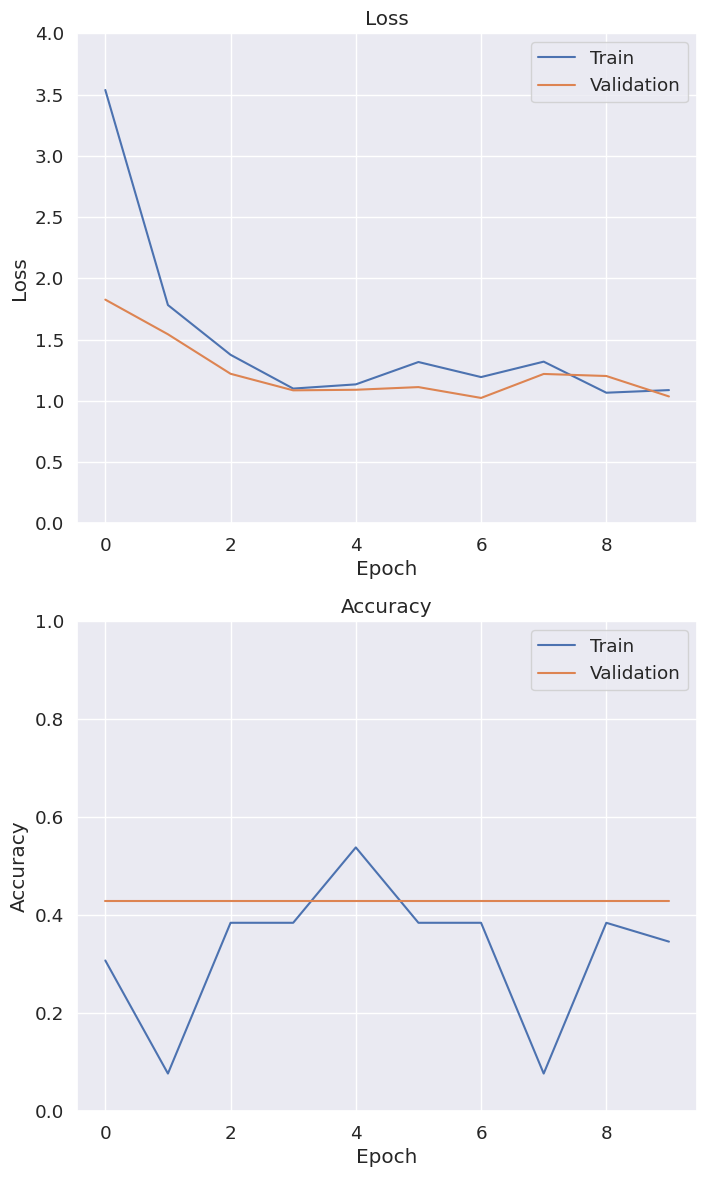

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0000e+00 - loss: 1.3990
Test results: {'accuracy': 0.0, 'loss': 1.3989577293395996}


ValueError: Input 0 of layer "functional_33" is incompatible with the layer: expected shape=(None, 20, 240, 200, 3), found shape=(2, 20, 200, 240, 3)

In [67]:
# Plot training history
plot_history(history)

# Evaluate on test set
test_results = model.evaluate(test_ds, return_dict=True)
print("Test results:", test_results)

# Get the labels from the train generator mapping
train_gen = FrameGenerator(split_map["train"], N_FRAMES)
labels = [label for label, _ in sorted(train_gen.class_ids_for_name.items(), key=lambda x: x[1])]

# Actual vs predicted for test dataset
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'Test')

precision, recall = calculate_classification_metrics(actual, predicted, labels)
print("Precision per class:", precision)
print("Recall per class:", recall)